In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import scipy.stats as ss
from scipy.interpolate import interp1d
from scipy.special import expit
from fractions import Fraction
from empiricaldist import Pmf, Cdf
import matplotlib.pyplot as plt
from collections import Counter
import statsmodels.formula.api as smfa

In [2]:
from data.utils import odds_to_prob, odds, make_dice, add_dist_seq, make_binomial

In [3]:
prior_odds = 1
likelihood_ratio_van = (3/4) / (1/2)
likelihood_ratio_cho = (1/4) / (1/2)
post_odds = prior_odds * likelihood_ratio_van
post_odds, odds_to_prob(post_odds)

(1.5, 0.6)

In [4]:
post_odds *= likelihood_ratio_cho
post_odds, odds_to_prob(post_odds)

(0.75, 0.42857142857142855)

In [6]:
like1 = 0.01
like2 = 0.6 * 0.01 * 2
likelihood_ratio = like1 / like2
post_odds = 1 * likelihood_ratio
post_odds, odds_to_prob(post_odds)

(0.8333333333333334, 0.45454545454545453)

In [7]:
dice = make_dice(6)

<AxesSubplot:>

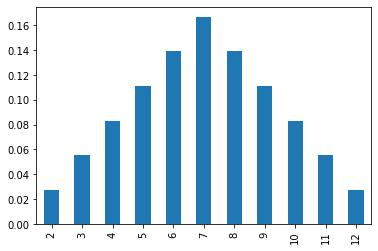

In [9]:
twice = Pmf.add_dist(dice, dice)
twice.plot.bar()

<AxesSubplot:>

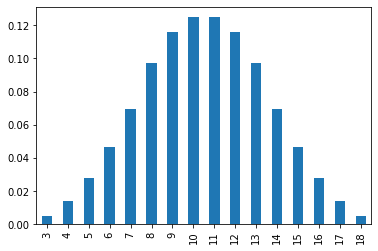

In [10]:
thr_times = dice.add_dist(dice).add_dist(dice)
thr_times.plot.bar()

<AxesSubplot:>

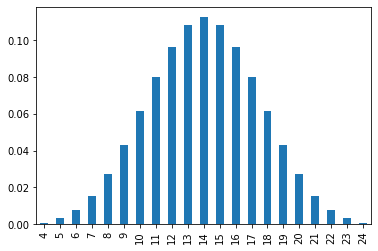

In [11]:
four_times = add_dist_seq([dice] * 4)
four_times.plot.bar()

In [12]:
n = 35
num_sensitive = 10
num_insensitive = n - num_sensitive

In [14]:
dist_sensitive = make_binomial(num_sensitive, 0.95)
dist_insensitive = make_binomial(num_insensitive, 0.4)
dist_total = Pmf.add_dist(dist_sensitive, dist_insensitive)
dist_total.head(10)

,probs
0,2.776395e-19
1,5.737884e-17
2,5.426465e-15
3,3.109132e-13
4,1.204494e-11
5,3.335553e-10
6,6.810800e-09
7,1.043774e-07
8,1.212985e-06
9,1.076220e-05


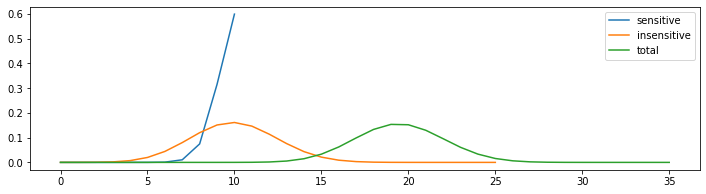

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
dist_sensitive.plot(label='sensitive', ax=ax)
dist_insensitive.plot(label='insensitive', ax=ax)
dist_total.plot(label='total', ax=ax)
plt.legend()
plt.show()

In [17]:
table = pd.DataFrame()
for num_sensitive in range(0, n + 1):
    num_insensitive = n - num_sensitive
    dist_sensitive = make_binomial(num_sensitive, 0.95)
    dist_insensitive = make_binomial(num_insensitive, 0.40)
    dist_total = Pmf.add_dist(dist_sensitive, dist_insensitive)
    table[num_sensitive] = dist_total
# index가 num_sensitive 인원의 수, columns는 그에 대한 likelihood의 분포
table.head()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,1.719071e-08,1.432559e-09,1.193799e-10,9.948326e-12,8.290272e-13,6.908560e-14,5.757133e-15,4.797611e-16,3.998009e-17,3.331674e-18,...,1.501694e-36,1.251411e-37,1.042843e-38,8.690357e-40,7.241964e-41,6.034970e-42,5.029142e-43,4.190952e-44,3.492460e-45,2.910383e-46
1,4.011165e-07,5.968996e-08,7.162795e-09,7.792856e-10,8.013930e-11,7.944844e-12,7.676178e-13,7.276377e-14,6.796616e-15,6.274653e-16,...,7.508469e-34,6.486483e-35,5.596590e-36,4.823148e-37,4.152060e-38,3.570691e-39,3.067777e-40,2.633315e-41,2.258457e-42,1.935405e-43
2,4.545987e-06,9.741401e-07,1.709122e-07,2.506426e-08,3.269131e-09,3.940182e-10,4.490244e-11,4.908756e-12,5.197412e-13,5.365476e-14,...,1.806613e-31,1.620070e-32,1.449030e-33,1.292922e-34,1.151034e-35,1.022555e-36,9.066202e-38,8.023344e-39,7.088005e-40,6.251357e-41
3,3.333724e-05,9.326490e-06,2.205654e-06,4.377061e-07,7.398116e-08,1.107854e-08,1.517139e-09,1.942513e-10,2.361331e-11,2.754929e-12,...,2.784933e-29,2.596024e-30,2.410204e-31,2.229314e-32,2.054801e-33,1.887764e-34,1.728997e-35,1.579030e-36,1.438169e-37,1.306534e-38
4,1.777986e-04,6.138285e-05,1.841174e-05,4.734794e-06,1.038280e-06,1.962745e-07,3.288580e-08,5.013120e-09,7.095823e-10,9.468298e-11,...,3.089268e-27,2.998031e-28,2.893328e-29,2.777860e-30,2.654159e-31,2.524558e-32,2.391168e-33,2.255871e-34,2.120317e-35,1.985931e-36


<AxesSubplot:>

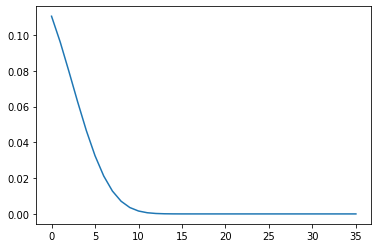

In [21]:
# x축의 숫자는 num_sensitive의 숫자 → 12개가 제대로 분류된 경우에 대한 num_sensitive 수의 likelihood
table.loc[12].plot()

<AxesSubplot:>

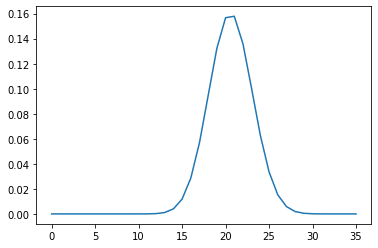

In [23]:
# num_sensitive가 12명일 경우 글루텐 분류의 likelihood
table.loc[:, 12].plot()

In [24]:
hypos = np.arange(n + 1)
prior = Pmf(1, hypos)
likelihood1 = table.loc[12]
likelihood2 = table.loc[20]
posterior1 = prior * likelihood1
posterior1.normalize()
posterior2 = prior * likelihood2
posterior2.normalize()
posterior2.head()

,probs
0,0.009423
1,0.013125
2,0.017925


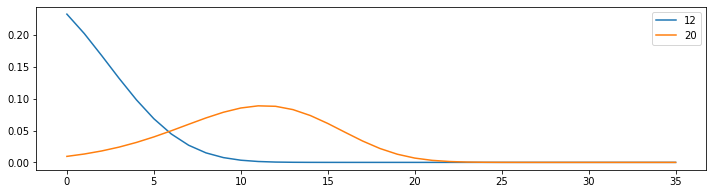

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
posterior1.plot(label='12', ax=ax)
posterior2.plot(label='20', ax=ax)
plt.legend()
plt.show()